#### Load Dependencies

In [ ]:
# pip install codecarbon

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForMaskedLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#from codecarbon import EmissionsTracker


In [ ]:
# current_directory = Path.cwd()
# base_directory = current_directory.parent
# results_file_sample = base_directory/'data'/'...'

#### Load And Inspect Data

In [ ]:
data_path = '/content/fixed_examples_v02.csv'
data = pd.read_csv(data_path, delimiter="/")
data.head()

,skills,context,buzzwords,action_verbs,verb_tense,target
0,JavaScript,I have developed interactive front-end applica...,interactive; front-end; applications,developed,past,1.0
1,Data Visualization,Data Visualization is a skill I plan to learn...,learn,learn,present,0.0
2,React,My recent projects involved creating dynamic ...,dynamic; web pages; projects,creating,past,1.0
3,Machine Learning,I’m currently undertaking a course to underst...,fundamentals; course,undertaking,present,0.0
4,SQL,"In my previous role, I was responsible for da...",database management; previous role; responsible,was responsible,past,1.0


In [ ]:
# Convert the target column to integer if it's not already
if data['target'].dtype != 'int64':
    try:
        data['target'] = data['target'].astype(int)
        print("Target column converted to integer.")
    except ValueError:
        print("Conversion to integer failed. Check if all values in the target column are numeric.")
else:
    print('Target values are in correct format')

Target column converted to integer.


#### Assign Variables

In [ ]:
# Pre-trained model and tokenizer
pretrained_model_name = 'bert-base-uncased'
pretrained_tokenizer_name = "bert-base-uncased"

In [ ]:
features_for_fine_tuning = data['context']
target_for_fine_tuning = data['target']

In [ ]:
# Hyperparameters and other important variables
# batch_sizes = [8]
batch_sizes = [8, 16, 24, 32, 64]
epochs = 10

In [ ]:
# Name of fine-tuned model to be exported
fine_tuned_model_name = 'screen_bert_v0_2.pth'
tokenizer_directory_name = 'tokenizer_directory'

In [ ]:
# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

#### Check Data

Number of values for 'Not Skilled' (0): 250
Number of values for 'Skilled' (1): 250
 


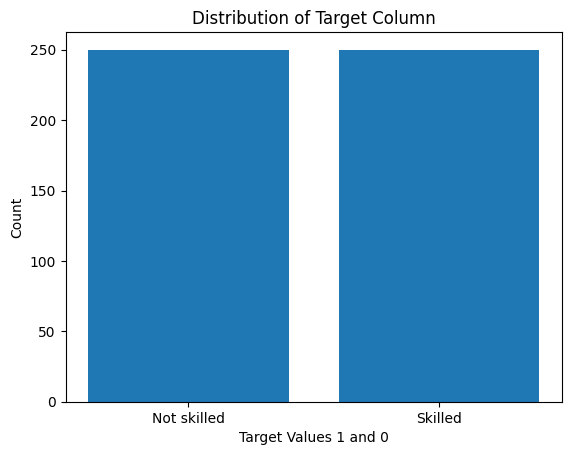

In [ ]:
# Plot and check whether data is balanced
target_counts = data['target'].value_counts()
print("Number of values for 'Not Skilled' (0):", target_counts[0])
print("Number of values for 'Skilled' (1):", target_counts[1])
print(' ')

plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Target Values 1 and 0')
plt.ylabel('Count')
plt.title('Distribution of Target Column')
plt.xticks(target_counts.index, ['Skilled','Not skilled'])
plt.show()

#### Helper Functions For Training, Evaluation, Plotting

In [ ]:
def create_dataloader(encodings, labels, batch_size):
    """Create DataLoader for data with given batch size."""
    print('entered create_dataloader function')
    dataset = TensorDataset(torch.tensor(encodings['input_ids']),
                                  torch.tensor(encodings['attention_mask']),
                                  labels)
    print('created dataset')
    sampler = RandomSampler(dataset)
    print('randomly sampled stuff ')
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)

In [ ]:
# to be updated
from sklearn.model_selection import StratifiedKFold
def k_fold_train_validate(texts, labels,
                    # val_dataset
                    pretrained_tokenizer,
                    model, optimizer, device, epochs, batch_size,
                    n_splits=5):

    print(type(labels.to_list()[0]))


    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=n_splits,
                        shuffle=True,
                        random_state=42)
    print("Strategy is set")

    train_loss_per_fold = []
    accuracy_per_fold = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(texts, labels)):
        print('fold', fold)
        print('train_index', train_index)
        print('val_index', val_index)

        train_texts = [texts.to_list()[i] for i in train_index]
        train_labels = [labels.to_list()[i] for i in train_index]
        val_texts = [texts.to_list()[i] for i in val_index]
        val_labels = [labels.to_list()[i] for i in val_index]

        print('split completed')

        print(type(train_labels[0]), type(val_labels[0]))
        train_labels = torch.tensor(train_labels)
        val_labels = torch.tensor(val_labels)
        print(type(train_labels), type(val_labels))

        train_encodings = pretrained_tokenizer(train_texts, truncation=True, padding=True)
        print("train_encodings done")
        val_encodings = pretrained_tokenizer(val_texts, truncation=True, padding=True)
        print("val_encodings done")

        train_dataloader = create_dataloader(train_encodings,
                                             train_labels,
                                             batch_size=batch_size,
                                             )
        print("train_dataloader ready to play")

        val_dataloader = create_dataloader(val_encodings,
                                           val_labels,
                                           batch_size=batch_size)
        print("val_dataloader ready to play")

        avg_train_loss = train_model(model, train_dataloader, optimizer, device, epochs, batch_size)
        accuracy = evaluate_model(model, val_dataloader, device)

        train_loss_per_fold.append(avg_train_loss)
        accuracy_per_fold.append(accuracy)

    return train_loss_per_fold, accuracy_per_fold

In [ ]:
[0.23, 0.67]  -> argmax  -> 1

In [ ]:
def train_model(optimizer, epochs, model, dataloader, device):
    """Training loop for the model."""

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps = epochs * dataloader.dataset.__len__()/ batch_size
                                                )
    # Set to training mode
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for step, batch in enumerate(dataloader):

        # progress update after every 50 batches
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # push current dataloader batch to respective device
        batch = tuple(t.to(device) for t in batch)

        input_ids, attention_mask, labels = batch

        # clear optimizer gradients
        optimizer.zero_grad()

        # get model predictions for the current batch
        logits = model(input_ids, attention_mask)

        # compute the loss between actual and predicted values
        loss = nn.CrossEntropyLoss()(logits, labels)

        # add on to the total loss
        total_loss += loss.item()

        # compute accuracy for the current batch
        batch_predictions = torch.argmax(logits, dim=1)
        predictions.extend(batch_predictions.cpu().numpy())

        # store true labels
        true_labels.extend(labels.cpu().numpy())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0 to prevent exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        scheduler.step()

    # compute training loss and accuracy of epoch
    avg_train_loss = total_loss / len(dataloader)
    total_train_accuracy = accuracy_score(true_labels, predictions)


    return avg_train_loss, total_train_accuracy

In [ ]:
def evaluate_model(model, dataloader, device):

    # deactivate dropout layers
    model.eval()

    total_loss = 0
    predictions = []
    true_labels = []

    # iterate over batches
    for step,batch in enumerate(dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print('Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # push batch to device
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            logits = model(input_ids, attention_mask)
            # compute the loss between actual and predicted values
            loss = nn.CrossEntropyLoss()(logits, labels)
            # add on to the total loss
            total_loss += loss.item()

            # compute accuracy for the current batch
            batch_predictions = torch.argmax(logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy())

            # store true labels
            true_labels.extend(labels.cpu().numpy())

    # compute training loss and accuracy of epoch
    avg_loss = total_loss / len(dataloader)
    total_accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, total_accuracy

In [ ]:
def validate_model(model):
    pass

In [ ]:
def plot_training_results(train_losses, epochs, batch_size):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_xticks(range(1, epochs + 1))  # Set x-ticks to show only integer epochs

    # Add a title and a legend
    fig.tight_layout()
    fig.suptitle(f'Training Loss over Epochs (Batch Size: {batch_size})', fontsize=14, y=1.05)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

    # loss and val_loss, training_acc, val_acc per epoch
    # avg_train_loss per epoch

    # train_model returns avg_train_loss_per_epoch list

In [ ]:
def train_and_evaluate_model(train_encodings, val_encodings,
                             train_labels, val_labels,
                             batch_size, epochs, model, device,
                             ):


    train_dataloader = create_dataloader(train_encodings,
                                         train_labels,
                                         batch_size=batch_size,
                                         )
    print("train_dataloader ready to play")

    val_dataloader = create_dataloader(val_encodings,
                                       val_labels,
                                       batch_size=batch_size
                                       )
    print("val_dataloader ready to play")

    # empty lists to store training and validation loss of each epoch
    train_losses=[]
    valid_losses=[]
    train_acc=[]
    valid_acc=[]

    print("Start training ...")
    for epoch in range(epochs):
        avg_train_loss, avg_train_accuracy = train_model(optimizer,
                                                         epochs,
                                                         model,
                                                         train_dataloader,
                                                         device)
        avg_val_loss, avg_val_accuracy = evaluate_model(model, val_dataloader, device)

        print(f'Epoch {epoch}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')
        print(f'Training Accuracy: {avg_train_accuracy:.3f}, Validation Accuracy: {avg_val_accuracy:.3f}')

        # document losses and acc
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        train_acc.append(avg_train_accuracy)
        valid_acc.append(avg_val_accuracy)

    return train_losses, valid_losses, train_acc, valid_acc

#### Fine-Tuning Pre-Trained Model

In [ ]:
# Split data into train, test and validation sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    features_for_fine_tuning,
    target_for_fine_tuning,
    test_size=0.2,
    stratify = target_for_fine_tuning,
    random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify = temp_labels,
    random_state=42
)

# Validate sizes and proportion of target
print(train_texts.shape, test_texts.shape, val_texts.shape)
print(train_labels.shape, test_labels.shape, val_labels.shape)
print('---')
print(train_labels.value_counts(normalize=True))
print(test_labels.value_counts(normalize=True))
print(val_labels.value_counts(normalize=True))

(400,) (50,) (50,)
(400,) (50,) (50,)
---
target
1    0.5
0    0.5
Name: proportion, dtype: float64
target
0    0.5
1    0.5
Name: proportion, dtype: float64
target
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# Load tokenizer
pretrained_tokenizer = BertTokenizer.from_pretrained(pretrained_tokenizer_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize and encode text data
test_encodings = pretrained_tokenizer(test_texts.tolist(),
                                      truncation=True,
                                      padding=True)

train_encodings = pretrained_tokenizer(train_texts.tolist(),
                                       truncation=True,
                                       padding=True)

val_encodings = pretrained_tokenizer(val_texts.tolist(),
                                     truncation=True,
                                     padding=True)

print("Encodings done")

Encodings done


In [ ]:
# Convert Convert Integer Sequences from Labels to Tensors
train_labels = torch.tensor(train_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())
print("Converting labels to tensors done")

Converting labels to tensors done


In [ ]:
# Prepare for model loading. If running on GPU, assign compute unified device architecture
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU computation device: {device}')
else:
    device = 'cpu'
    print(f'Computation device: {device}')


GPU computation device: cuda


In [ ]:
# Define a classification model on top of pre-trained model
class ScreenBert(nn.Module):
    def __init__(self, pretrained_model_name, droput_prob=0.1):
        super(ScreenBert, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(droput_prob)
        self.fc = nn.Linear(768, 2)  # 2 classes: knowledge vs no_knowledge
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [ ]:
# This is the model instance to be fine-tuned and exported eventually
# It is directed to the respective computation device
#BaseBert Model
model = ScreenBert(pretrained_model_name).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# # If needed: Print the names of the parameters
# for name, param in model.named_parameters():
#     print(name)

In [ ]:
# Training loop with initialised CodeCarbon tracker


batch_size_data = {}
best_model = None
best_val_acc = 0.0

for batch_size in batch_sizes:
  print(f'Batch Size: {batch_size}')

  # Instantiate the model and move it to the appropriate device
  #Base BERT model
  model = ScreenBert(pretrained_model_name).to(device)

  #Distilbert Model
  # model = ScreenDistilBert(pretrained_model_name).to(device)

  optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

  # Train and evaluate the model
  train_losses, valid_losses, train_acc, valid_acc = train_and_evaluate_model(train_encodings,
                                                                              val_encodings,
                                                                              train_labels,
                                                                              val_labels,
                                                                              batch_size,
                                                                              epochs,
                                                                              model,
                                                                              device)

  # Store the results in a nested dictionary
  batch_size_data[batch_size] = {
      'train_losses': train_losses,
      'valid_losses': valid_losses,
      'train_acc': train_acc,
      'valid_acc': valid_acc
  }

  # Save the trained model
  #model_name = f'screen_bert_batch_size_{batch_size}.pth'
  model_name = f'screen_bert_batch_size_{batch_size}.pth'
  torch.save(model.state_dict(), model_name)

  # Track the best model based on validation accuracy
  if valid_acc[-1] > best_val_acc:
      best_val_acc = valid_acc[-1]
      best_model = model
      best_model_name = model_name

# Print the best validation accuracy and model's state dictionary
print(f'Best Validation Accuracy: {best_val_acc}')
print(f'Best model = {best_model_name}')


Batch Size: 8


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


entered create_dataloader function
created dataset
randomly sampled stuff 
train_dataloader ready to play
entered create_dataloader function
created dataset
randomly sampled stuff 
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.329, Validation Loss: 0.104
Training Accuracy: 0.892, Validation Accuracy: 0.960
Epoch 1/10
Training Loss: 0.016, Validation Loss: 0.081
Training Accuracy: 0.998, Validation Accuracy: 0.980
Epoch 2/10
Training Loss: 0.001, Validation Loss: 0.126
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 3/10
Training Loss: 0.002, Validation Loss: 0.230
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 4/10
Training Loss: 0.000, Validation Loss: 0.262
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 5/10
Training Loss: 0.000, Validation Loss: 0.273
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 6/10
Training Loss: 0.000, Validation Loss: 0.283
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 7/

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


entered create_dataloader function
created dataset
randomly sampled stuff 
train_dataloader ready to play
entered create_dataloader function
created dataset
randomly sampled stuff 
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.455, Validation Loss: 0.163
Training Accuracy: 0.823, Validation Accuracy: 0.960
Epoch 1/10
Training Loss: 0.109, Validation Loss: 0.083
Training Accuracy: 0.980, Validation Accuracy: 0.980
Epoch 2/10
Training Loss: 0.014, Validation Loss: 0.019
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 3/10
Training Loss: 0.002, Validation Loss: 0.021
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 4/10
Training Loss: 0.001, Validation Loss: 0.060
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 5/10
Training Loss: 0.001, Validation Loss: 0.044
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 6/10
Training Loss: 0.001, Validation Loss: 0.043
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 7/

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


entered create_dataloader function
created dataset
randomly sampled stuff 
train_dataloader ready to play
entered create_dataloader function
created dataset
randomly sampled stuff 
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.559, Validation Loss: 0.258
Training Accuracy: 0.772, Validation Accuracy: 0.940
Epoch 1/10
Training Loss: 0.194, Validation Loss: 0.052
Training Accuracy: 0.963, Validation Accuracy: 1.000
Epoch 2/10
Training Loss: 0.032, Validation Loss: 0.025
Training Accuracy: 0.998, Validation Accuracy: 0.980
Epoch 3/10
Training Loss: 0.005, Validation Loss: 0.014
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 4/10
Training Loss: 0.002, Validation Loss: 0.017
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 5/10
Training Loss: 0.001, Validation Loss: 0.024
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 6/10
Training Loss: 0.001, Validation Loss: 0.026
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 7/

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


entered create_dataloader function
created dataset
randomly sampled stuff 
train_dataloader ready to play
entered create_dataloader function
created dataset
randomly sampled stuff 
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.475, Validation Loss: 0.241
Training Accuracy: 0.835, Validation Accuracy: 0.980
Epoch 1/10
Training Loss: 0.198, Validation Loss: 0.160
Training Accuracy: 0.973, Validation Accuracy: 0.960
Epoch 2/10
Training Loss: 0.079, Validation Loss: 0.103
Training Accuracy: 0.990, Validation Accuracy: 0.960
Epoch 3/10
Training Loss: 0.027, Validation Loss: 0.165
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 4/10
Training Loss: 0.009, Validation Loss: 0.125
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 5/10
Training Loss: 0.004, Validation Loss: 0.167
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 6/10
Training Loss: 0.002, Validation Loss: 0.106
Training Accuracy: 1.000, Validation Accuracy: 0.960
Epoch 7/

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


entered create_dataloader function
created dataset
randomly sampled stuff 
train_dataloader ready to play
entered create_dataloader function
created dataset
randomly sampled stuff 
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.569, Validation Loss: 0.395
Training Accuracy: 0.752, Validation Accuracy: 0.960
Epoch 1/10
Training Loss: 0.358, Validation Loss: 0.275
Training Accuracy: 0.960, Validation Accuracy: 0.960
Epoch 2/10
Training Loss: 0.242, Validation Loss: 0.192
Training Accuracy: 0.980, Validation Accuracy: 0.980
Epoch 3/10
Training Loss: 0.155, Validation Loss: 0.112
Training Accuracy: 0.993, Validation Accuracy: 1.000
Epoch 4/10
Training Loss: 0.091, Validation Loss: 0.074
Training Accuracy: 0.995, Validation Accuracy: 0.980
Epoch 5/10
Training Loss: 0.046, Validation Loss: 0.077
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 6/10
Training Loss: 0.022, Validation Loss: 0.039
Training Accuracy: 1.000, Validation Accuracy: 0.980
Epoch 7/

In [ ]:
##Graph each batch size
# Define colors for each batch size
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot losses for each batch size
for idx, (batch_size, data) in enumerate(batch_data.items()):
    train_losses = data['train_losses']
    valid_losses = data['valid_losses']
    epochs = range(1, len(train_losses) + 1)
    color = colors[idx % len(colors)]  # Cycle through colors for each batch size

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='--', color=color, label='Train Loss')
    plt.plot(epochs, valid_losses, linestyle='-', color=color, label='Validation Loss')
    plt.title(f'Training and Validation Loss (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot accuracies for each batch size
for idx, (batch_size, data) in enumerate(batch_data.items()):
    train_acc = data['train_acc']
    valid_acc = data['valid_acc']
    epochs = range(1, len(train_acc) + 1)
    color = colors[idx % len(colors)]  # Cycle through colors for each batch size

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, linestyle='--', color=color, label='Train Accuracy')
    plt.plot(epochs, valid_acc, linestyle='-', color=color, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


NameError: name 'batch_data' is not defined

# Evaluate model performance on unseen test data

In [ ]:
print(best_model_name)

In [ ]:
test_dataloader = create_dataloader(test_encodings, test_labels, batch_size=16)
test_loss, test_acc = evaluate_model(best_model, test_dataloader, device)
test_loss, test_acc

In [ ]:
# Evaluation
best_model.eval()
predictions = []
true_labels = []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        logits = best_model(input_ids, attention_mask)
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

In [ ]:
#confusion matrix
matrix  = confusion_matrix(true_labels, predictions)
matrix

In [ ]:
# # Get size of model if needed
# import os
# for batch_size in batch_sizes:
#   model_name = f'screen_bert_batch_size_{batch_size}.pth'
#   # torch.save(model.state_dict(), model_name)

#   # Get the file size in bytes
#   file_size_bytes = os.path.getsize(f'/content/{model_name}')

#   # Convert bytes to megabytes (MB)
#   file_size_mb = file_size_bytes / (1024 * 1024)

#   print(f"File size of saved model: {file_size_mb:.2f} MB")

In [ ]:
import matplotlib.pyplot as plt

# Plot for losses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot losses
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='tab:red')
ax1.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_xticks(range(1, epochs + 1))

# Add legend to the first plot
ax1.legend()

# Plot accuracies
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='tab:green')
ax2.plot(range(1, epochs + 1), valid_acc, label='Validation Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add legend to the second plot
ax2.legend()

# Add title to the whole figure
fig.suptitle(f'Training Metrics over Epochs (Batch Size: {batch_size})', fontsize=14, y=0.95)

plt.show()


In [ ]:
# # Visualize results
# plot_training_results(epoch_training_losses, accuracy_scores, epochs)

#### Evaluation Of Fine-Tuned Model

In [ ]:
# model.eval()
# predictions = []
# true_labels = []
# for batch in test_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     input_ids, attention_mask, labels = batch
#     with torch.no_grad():
#         logits = model(input_ids, attention_mask)
#     preds = torch.argmax(logits, axis=1)
#     predictions.extend(preds.cpu().numpy())
#     true_labels.extend(labels.cpu().numpy())

In [ ]:
# accuracy = accuracy_score(true_labels, predictions)
# print("Accuracy on validation data:", accuracy)

In [ ]:
# matrix  = confusion_matrix(true_labels, predictions)
# matrix

#### Export The Fine-Tuned Model

In [ ]:
# # Uncomment if export is needed
# torch.save(model.state_dict(), fine_tuned_model_name)
# tokenizer.save_pretrained(tokenizer_directory_name)

# Testing model import for pipeline

In [ ]:
model_path = '/content/screen_bert_batch_size_16.pth'

In [ ]:
def classify_this(text):
  inputs = pretrained_tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)
  with torch.no_grad():
    output = best_model(input_ids, attention_mask)
  return torch.argmax(output, dim=1).item()

In [ ]:
text1 = '''I've heard the term machine learning before, but I must admit that I don't have extensive knowledge about them.'''

In [ ]:
classify_this(text1)

0

In [ ]:
text3 = "For example, in a project I worked on during my studies, I used a CNN to classify different types of fruits from images."

In [ ]:
classify_this(text3)

1

In [ ]:
'''i know <SKILL>'''

'i know <SKILL>'

In [ ]:
text2 = '''i know <SKILL>'''

In [ ]:
text2 = '''i know computer'''
classify_this(text2)

1

In [ ]:
text2 = '''i know science'''
classify_this(text2)

1

In [ ]:
text2 = '''i know computer science'''
classify_this(text2)

0